In [1]:
from qTools import *
import Cahit as ck

import numpy as np

import matplotlib.pyplot as plt
import datetime

### System parameters

In [2]:
resonatorDimension = 200
g = 1.79
qfreq = 0
resFreq = 1

### Simulation Parameters and Settings

In [3]:
qSim = Simulation()
qSim.finalTime = 2
qSim.stepSize = 0.02
qSim.delStates = True

### Composite System Creation and Components

In [4]:
JCSys = QuantumSystem(name='JC')
RabiSys = QuantumSystem(name='Rabi')

cavJC = JCSys.addSubSys(Cavity(dimension=resonatorDimension, frequency=resFreq))
qubJC = JCSys.createSubSys(Qubit, frequency=qfreq)

#cavRabi = RabiSys.addSubSys(cavJC.copy())
cavRabi = RabiSys.addSubSys(cavJC.copy(),frequency=2*resFreq)
qubRabi = RabiSys.addSubSys(qubJC.copy())

Cavity requires a dimension
Qubit requires a dimension
Cavity requires a dimension
Qubit requires a dimension


#### Coupling term and initial state

In [5]:
JCcoupling = JCSys.JC(cavJC, qubJC, g)
RabiCoupling = RabiSys.Rabi(cavRabi, qubRabi, g)

#JCSys.initialState = [0,0]
cavJC.initialState = 0
qubJC.initialState = basis(2,0)

cavRabi.initialState = 0
qubRabi.initialState = basis(2,0)

### Define the Digital Algorithm

In [6]:
JCunitary = freeEvolution(ratio=0.5, superSys=JCSys)
#qubset = JCunitary.createUpdate(system=qubJC, key='frequency', value=0)

bitFlip = xGate(implementation='instant', superSys=qubJC)
#AJC = freeEvolution(superSys=JCSys)

#AJCunitary = qProtocol(steps=[bitFlip, AJC, bitFlip])
digitalRabi = qProtocol(superSys=JCSys, steps=[JCunitary, bitFlip, JCunitary, JCunitary, bitFlip, JCunitary], name='DigitalRabi')

### Add the systems into Simulation interface

In [7]:
qSim.addSubSys(JCSys, digitalRabi)
qSim.addSubSys(RabiSys)

### Define Parameter Sweeps

In [8]:
'''cavJCFreqSweep = qSim.Sweep.createSweep(system=cavJC, sweepKey='frequency', sweepList=np.arange(-2, 2+0.005, 0.005))
cavRabiFreqSweep = qSim.Sweep.createSweep(system=cavRabi, sweepKey='frequency', sweepList=np.arange(-4, 4+0.01, 0.01))'''
stepSizeSweep = qSim.Sweep.createSweep(system=qSim, sweepKey='stepSize', sweepList=np.arange(0.001,0.1,0.001))

### Define the (run-time) compute

In [9]:
cavParity = parityEXP(cavJC.freeMat)
cavFree = cavJC.freeMat

# Phase space 
xvec = np.linspace(-7, 7, 400)

subSysDimsOrdered = JCSys.subSysDimensions

def expectn(qSim, stateJC, stateRabi):
    # Observable expectations
    # Cavity Parity
    qSim.getResultByName('RabiResults').resultsKeyValList = ('Cavity Parity', expectationKet(cavParity, stateRabi))
    qSim.getResultByName('JCDigitalRabiResults').resultsKeyValList = ('Cavity Parity', expectationKet(cavParity, stateJC))
    # Photon number
    qSim.getResultByName('RabiResults').resultsKeyValList = ('Photon Number', expectationKet(cavFree, stateRabi))
    qSim.getResultByName('JCDigitalRabiResults').resultsKeyValList = ('Photon Number', expectationKet(cavFree, stateJC))

    # Simulation fidelity
    qSim.qRes.resultsKeyValList = ['simFidelity', fidelityKet(stateJC, stateRabi)]
    
    # Fidelity decay under resonator frequency perturbationN
    # if sweeping step size, it is required to use two different frequencies, so it is easier and more convenient to use 4 systems
    # protocols can be arranged to avoid extra exponentiation (in the digital case)
    # if doing multi-processing and sweeping resonator frequency, it is not possible to use the "previous time series" 
    # because they are simulated simultaneously on different cores
    # so the only option in both cases with multi-processing, it to use 4 systems
    #qSim.getResultByName('RabiResults').resultsKeyValList = ('FidelityDecay', fidelityKet(stateJC, stateJCPert))

    #qSim.getResultByName('JCDigitalRabiResults').resultsKeyValList = ('PhotonNumber', fidelityKet(stateRabi, stateRabiPert))

    # Fidelity to initial state
    # Below is another possibility to reach different results objects, all of above can be included below, which would simplfy the script a lot
    for protocol, qsys in qSim.subSys.items():
        # Fidelity to initial state
        protocol.qRes.resultsKeyValList = ('Fidelity to initial', fidelityKet(protocol.lastState, qsys.initialState))

        # delocalisation measure (number of principle components)
        protocol.qRes.resultsKeyValList = ('NPC', iprKetNB(protocol.lastState))

        # for the Wigner and qubit entropy, we need to take the partial trace. also, it is easier and more efficient to use partial traced state for Fock populations
        # Note: partial trace returns density matrices
        cavState = partialTrace(keep=[0], dims=subSysDimsOrdered, state=protocol.lastState)
        qubState = partialTrace(keep=[1], dims=subSysDimsOrdered, state=protocol.lastState)
        
        # Fock state populations by getting the diagonals.
        # the reason for np.real is that, even though it is real, it still has complex part that is zero, so this gets rid of extra information for the memory
        fockPops = np.real(cavState.diagonal()) # useful in two ways, obviously this and eigenvector statistics, so they should be turned into a method in QT
        protocol.qRes.resultsKeyValList = ('Fock state populations', fockPops[0:10])
        protocol.qRes.averageKeyVal = ('Fock state populations Ave', fockPops[0:10])

        # calculating Wigner and time-averaged Wigner
        #WignerFunc = Wigner(cavState, xvec=xvec)
        #protocol.qRes.resultsKeyValList = ('Wigner', WignerFunc)
        #protocol.qRes.averageKeyVal = ('Wigner average', WignerFunc)

        # calculating qubit entropy and its time average
        qubEntropy = entropy(qubState)
        protocol.qRes.resultsKeyValList = ['Qubit entropy', qubEntropy]
        protocol.qRes.averageKeyVal = ('Qubit entropy average', qubEntropy)

    # BELOW ARE THE TREE DIFFERENT POSSIBLE SYNTAX THAT IS ALREADY AVAILABLE

    #qSim.qRes.results['simFidelity'].append(fidelityKet(stateJC, stateRabi))
    #qSim.qRes.resultsMethod('simFidelity', fidelityKet(stateJC, stateRabi))
    #qSim.qRes.resultsKeyValList = ['simFidelity', fidelityKet(stateJC, stateRabi)]

    #qSim.getResultByName('RabiResults').results['cavParity'].append(expectationKet(cavParity, stateRabi))
    #qSim.getResultByName('RabiResults').resultsMethod('cavParity', expectationKet(cavParity, stateRabi))
    #qSim.getResultByName('RabiResults').resultsKeyValList = ('cavParity', expectationKet(cavParity, stateRabi))
    
    #qSim.getResultByName('JCDigitalRabiResults').results['cavParity'].append(expectationKet(cavParity, stateJC))
    #qSim.getResultByName('JCDigitalRabiResults').resultsMethod('cavParity', expectationKet(cavParity, stateJC))
    #qSim.getResultByName('JCDigitalRabiResults').resultsKeyValList = ('cavParity', expectationKet(cavParity, stateJC))

qSim.compute = expectn

### Run the simulation

In [10]:
nw = datetime.datetime.now()

results = qSim.run(p=True, coreCount='all')

en = datetime.datetime.now()
print(en-nw)

0:01:20.357523


### Save Results

In [ ]:
path, fname = qSim.qRes.saveAll(fileName='trial', path='/Users/cahitkargi/Desktop')

### Plot the Results
---

Plotting is not part of the simulation library

In [ ]:
def plotRes(xList = cavRabiFreqSweep.sweepList):
    fig = plt.figure(figsize=(12,9))
    setC = [0.88, 0.25, 0.02, 0.6]

    axGrids = ck.Plotting.Functions.grid(3, 1, fig=fig)

    ck.Plotting.SimplePlots.colorPlot(xList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results['simFidelity'], ax=axGrids[0], gif=fig, setC=setC)
    ck.Plotting.SimplePlots.colorPlot(xList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.getResultByName('RabiResults').results['cavParity'], ax=axGrids[1], gif=fig, setC=setC)
    ck.Plotting.SimplePlots.colorPlot(xList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.getResultByName('JCDigitalRabiResults').results['cavParity'], ax=axGrids[2], gif=fig, setC=setC)

plotRes(cavRabiFreqSweep.sweepList)

In [ ]:
print(list(qSim.subSys.keys())[1].qRes.superSys.name)
print(list(qSim.subSys.keys())[1].name)
print(RabiSys._genericQSys__unitary.name)
print(qSim.getResultByName('RabiResults').superSys.name)

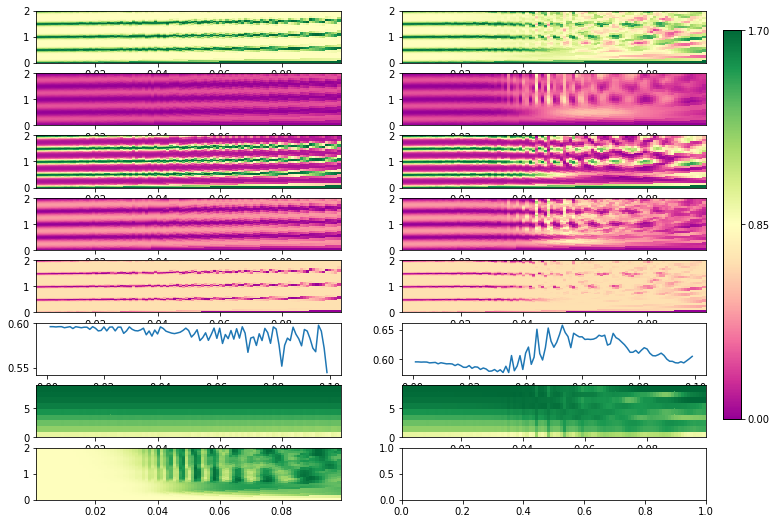

In [13]:
def plotRes(xList = stepSizeSweep.sweepList):
    fig = plt.figure(figsize=(12,9))
    setC = [0.92, 0.25, 0.02, 0.6]

    axGrids = ck.Plotting.Functions.grid(8, 2, fig=fig)

    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.qRes.results['simFidelity'], ax=axGrids[14], gif=fig, setC=setC, mapC='GrYl', maxC=1, minC=0)

    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('RabiResults').results['Cavity Parity'], ax=axGrids[0], gif=fig, setC=setC)
    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('JCDigitalRabiResults').results['Cavity Parity'], ax=axGrids[1], gif=fig, setC=setC)


    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('RabiResults').results['Photon Number'], ax=axGrids[2], gif=fig, setC=setC, maxC=20, minC=0)
    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('JCDigitalRabiResults').results['Photon Number'], ax=axGrids[3], gif=fig, setC=setC, maxC=20, minC=0)


    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('RabiResults').results['Fidelity to initial'], ax=axGrids[4], gif=fig, setC=setC, maxC=1, minC=0)
    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('JCDigitalRabiResults').results['Fidelity to initial'], ax=axGrids[5], gif=fig, setC=setC, maxC=1, minC=0)


    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('RabiResults').results['NPC'], ax=axGrids[6], gif=fig, setC=setC, maxC=20, minC=1)
    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('JCDigitalRabiResults').results['NPC'], ax=axGrids[7], gif=fig, setC=setC, maxC=20, minC=1)


    ck.Plotting.SimplePlots.colorPlot(xList, np.arange(0, 10, 1), qSim.getResultByName('RabiResults').results['Fock state populations Ave'], ax=axGrids[12], gif=fig, setC=setC, maxC=0.4, minC=0)
    ck.Plotting.SimplePlots.colorPlot(xList, np.arange(0, 10, 1), qSim.getResultByName('JCDigitalRabiResults').results['Fock state populations Ave'], ax=axGrids[13], gif=fig, setC=setC, maxC=0.4, minC=0)
    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('RabiResults').results['Qubit entropy'], ax=axGrids[8], gif=fig, setC=setC, maxC=1.7, minC=0)
    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('JCDigitalRabiResults').results['Qubit entropy'], ax=axGrids[9], gif=fig, setC=setC, maxC=1.7, minC=0)
    axGrids[10].plot(xList, qSim.getResultByName('RabiResults').results['Qubit entropy average'])
    axGrids[11].plot(xList, qSim.getResultByName('JCDigitalRabiResults').results['Qubit entropy average'])

plotRes()

In [ ]:
print(len(qSim.qRes.results['simFidelityAve']))
print(qSim.qRes.results['simFidelityAve'])

In [ ]:
average = [sum(l)/len(l) for l in qSim.qRes.results['simFidelity']]

In [ ]:
for i in range(len(average)):
    print(average[i] - qSim.qRes.results['simFidelityAve'][i])

In [ ]:
s = 0
for val in qSim.getResultByName('JCDigitalRabiResults').results['Fock state populations Ave'][0]:
    s += np.sqrt(val)
print(s)

In [ ]:
x = qSim.getResultByName('JCDigitalRabiResults').results['Fock state populations'][0][0]
print(qSim.getResultByName('JCDigitalRabiResults').results['Fock state populations'][0][1])
y = (x + qSim.getResultByName('JCDigitalRabiResults').results['Fock state populations'][0][1])/2
z = ((2*y) + qSim.getResultByName('JCDigitalRabiResults').results['Fock state populations'][0][2])/3
print(x)
print(y)
print(z)